## IMPORT PACKAGES

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import statistics

## LOAD DATASET

In [2]:
path = 'C:/datasets/insight for failed orders/'
os.listdir(path)

['data_offers.csv', 'data_orders.csv']

In [3]:
offers = pd.read_csv(path + 'data_offers.csv')
orders = pd.read_csv(path + 'data_orders.csv')

## CONNECT TO SQLITE3

In [4]:
conn = sqlite3.connect('data_orders.csv')

In [5]:
conn = sqlite3.connect('data_offers.csv')

In [6]:
cur = conn.cursor()

**BUSINESS UNDERSTANDING**

Gett, previously known as GetTaxi, is an Israeli-developed technology platform solely focused on corporate Ground Transportation Management (GTM). They have an application where clients can order taxis, and drivers can accept their rides (offers). At the moment, when the client clicks the Order button in the application, the matching system searches for the most relevant drivers and offers them the order. In this task, we would like to investigate some matching metrics for orders that did not completed successfully, i.e., the customer didn't end up getting a car.

Please complete the following tasks.

1. Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

2. Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

3. Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

4. Plot the distribution of average ETA by hours. How can this plot be explained?

**DATA UNDERSTANDING**

We have two data sets: data_orders and data_offers, both being stored in a CSV format.

The data_orders data set contains the following columns:

- **order_datetime** - time of the order
- **origin_longitude** - longitude of the order
- **origin_latitude** - latitude of the order
- **m_order_eta** - time before order arrival
- **order_gk** - order number
- **order_status_key** - status, an enumeration consisting of the following mapping:
    - **4** - cancelled by client,
    - **9** - cancelled by system, i.e., a reject
- **is_driver_assigned_key** - whether a driver has been assigned
- **cancellation_time_in_seconds** - how many seconds passed before cancellation

The data_offers data set is a simple map with 2 columns:

- **order_gk** - order number, associated with the same column from the orders data set
- **offer_id** - ID of an offer

In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB


In [8]:
offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334363 entries, 0 to 334362
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   order_gk  334363 non-null  int64
 1   offer_id  334363 non-null  int64
dtypes: int64(2)
memory usage: 5.1 MB


## Data Preparation

### Data Cleansing

### Check Missing Value

Orders Table

In [9]:
pd.isnull(orders).sum()

order_datetime                      0
origin_longitude                    0
origin_latitude                     0
m_order_eta                      7902
order_gk                            0
order_status_key                    0
is_driver_assigned_key              0
cancellations_time_in_seconds    3409
dtype: int64

In [10]:
orders['m_order_eta'].sort_values(ascending=False)

8604     1559.0
8987     1387.0
5311     1378.0
5452     1374.0
4655     1285.0
          ...  
10709       NaN
10710       NaN
10711       NaN
10712       NaN
10714       NaN
Name: m_order_eta, Length: 10716, dtype: float64

In [11]:
orders['m_order_eta'].fillna(int(orders['m_order_eta'].mean()), inplace=True)

In [12]:
orders['cancellations_time_in_seconds'].sort_values(ascending=False)

8369     4303.0
3442     4097.0
8473     3697.0
6825     2680.0
9924     2376.0
          ...  
10673       NaN
10682       NaN
10684       NaN
10685       NaN
10691       NaN
Name: cancellations_time_in_seconds, Length: 10716, dtype: float64

In [13]:
orders['cancellations_time_in_seconds'].fillna(int(orders['cancellations_time_in_seconds'].mean()), inplace=True)

In [14]:
pd.isnull(orders).sum()

order_datetime                   0
origin_longitude                 0
origin_latitude                  0
m_order_eta                      0
order_gk                         0
order_status_key                 0
is_driver_assigned_key           0
cancellations_time_in_seconds    0
dtype: int64

In [15]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    10716 non-null  float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  10716 non-null  float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB


Offers Table

In [16]:
pd.isnull(offers).sum()

order_gk    0
offer_id    0
dtype: int64

## Check Duplicate Data

Orders Table

In [17]:
orders[orders.duplicated(subset=['order_gk'], keep=False)]

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds


Offers Table

In [18]:
offers[offers.duplicated(subset=['order_gk'], keep=False)]

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196
...,...,...
334357,3000617576339,300051728177
334358,3000552921666,300050611632
334359,3000593796526,300051443024
334360,3000590955748,300051340498


In [19]:
offers = offers.drop_duplicates(subset=['order_gk'])

In [20]:
offers[offers.duplicated(subset=['order_gk'], keep=False)]

,order_gk,offer_id


In [21]:
offers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97967 entries, 0 to 334361
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   order_gk  97967 non-null  int64
 1   offer_id  97967 non-null  int64
dtypes: int64(2)
memory usage: 2.2 MB


## Data Manipulation

## Checking and Changing Data Type

Orders Table

In [22]:
orders.dtypes

order_datetime                    object
origin_longitude                 float64
origin_latitude                  float64
m_order_eta                      float64
order_gk                           int64
order_status_key                   int64
is_driver_assigned_key             int64
cancellations_time_in_seconds    float64
dtype: object

In [23]:
orders['order_datetime'] = pd.to_datetime(orders['order_datetime'])

In [24]:
orders['m_order_eta'] = orders['m_order_eta'].astype(int)

In [25]:
orders['order_gk'] = orders['order_gk'].astype(str)

In [26]:
orders['cancellations_time_in_seconds'] = orders['cancellations_time_in_seconds'].astype(int)

In [27]:
orders.dtypes

order_datetime                   datetime64[ns]
origin_longitude                        float64
origin_latitude                         float64
m_order_eta                               int32
order_gk                                 object
order_status_key                          int64
is_driver_assigned_key                    int64
cancellations_time_in_seconds             int32
dtype: object

Offers Table

In [28]:
offers.dtypes

order_gk    int64
offer_id    int64
dtype: object

In [29]:
offers['order_gk'] = offers['order_gk'].astype(str)

In [30]:
offers['offer_id'] = offers['offer_id'].astype(str)

In [31]:
offers.dtypes

order_gk    object
offer_id    object
dtype: object

## Renaming Columns

Orders Table

In [32]:
orders = orders.rename(columns={'m_order_eta': 'order_eta', 'order_gk': 'order_id', 'order_status_key': 'order_status',
                                'is_driver_assigned_key': 'driver_assigned', 'cancellations_time_in_seconds': 'cancellations',
                                'origin_longitude': 'longitude', 'origin_latitude': 'latitude'})

In [33]:
orders.head()

,order_datetime,longitude,latitude,order_eta,order_id,order_status,driver_assigned,cancellations
0,2023-05-01 18:08:07,-0.978916,51.456173,60,3000583041974,4,1,198
1,2023-05-01 20:57:32,-0.950385,51.456843,441,3000583116437,4,0,128
2,2023-05-01 12:07:50,-0.969520,51.455544,477,3000582891479,4,1,46
3,2023-05-01 13:50:20,-1.054671,51.460544,658,3000582941169,4,1,62
4,2023-05-01 21:24:45,-0.967605,51.458236,441,3000583140877,9,0,157


Offers Table

In [34]:
offers = offers.rename(columns={'order_gk': 'order_id'})

In [35]:
offers.head()

,order_id,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


## Handling Outliers

Orders Table

In [36]:
orders['order_eta'].describe()

count    10716.000000
mean       441.109089
std        147.567669
min         60.000000
25%        441.000000
50%        441.000000
75%        441.000000
max       1559.000000
Name: order_eta, dtype: float64

In [37]:
orders['cancellations'].describe()

count    10716.000000
mean       157.608249
std        176.186298
min          3.000000
25%         67.000000
50%        157.000000
75%        157.000000
max       4303.000000
Name: cancellations, dtype: float64

Text(0.5, 0, 'Table Orders')

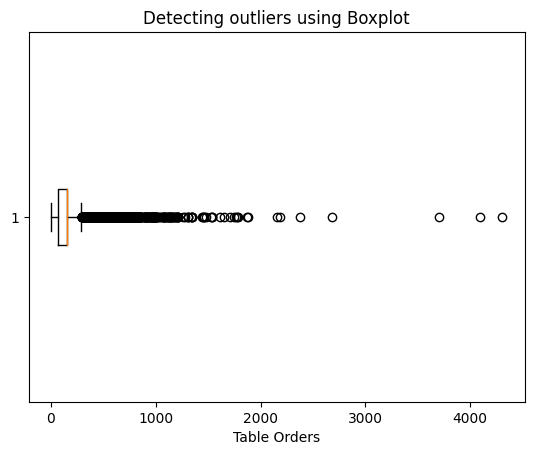

In [38]:
plt.boxplot(orders['cancellations'], vert=False)
plt.title("Detecting outliers using Boxplot")
plt.xlabel('Table Orders')

In [39]:
def detect_outliers(data):
    outliers = []
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    IQR = q3 - q1
    lower = q1 - (1.5 * IQR)
    upper = q3 + (1.5 * IQR)

    print('Q1 value in cancellations column is:', q1)
    print('Q3 value in cancellations column is:', q3)
    print('IQR value in cancellations column is:', IQR)
    print('Lower value in cancellations column is:', lower)
    print('Upper value in cancellations column is:', upper)

    for i in data: 
        if (i<lower or i>upper):
            outliers.append(i)
    return outliers
outliers = detect_outliers(orders['cancellations'])
print("Outliers from IQR method: ", outliers)

Q1 value in cancellations column is: 67.0
Q3 value in cancellations column is: 157.0
IQR value in cancellations column is: 90.0
Lower value in cancellations column is: -68.0
Upper value in cancellations column is: 292.0
Outliers from IQR method:  [293, 293, 293, 294, 295, 296, 296, 296, 296, 297, 297, 297, 298, 300, 300, 300, 301, 301, 301, 302, 302, 302, 303, 304, 304, 305, 306, 306, 306, 307, 308, 308, 308, 308, 310, 310, 310, 310, 310, 311, 311, 311, 311, 311, 311, 312, 312, 313, 313, 313, 314, 314, 314, 315, 315, 316, 317, 317, 317, 318, 319, 319, 319, 319, 319, 320, 320, 321, 321, 321, 321, 322, 323, 323, 324, 324, 324, 325, 325, 325, 325, 325, 325, 326, 326, 327, 327, 328, 328, 328, 328, 328, 329, 329, 329, 329, 331, 332, 333, 333, 333, 334, 335, 335, 336, 337, 339, 339, 339, 339, 339, 340, 340, 340, 340, 340, 341, 341, 341, 342, 343, 343, 343, 343, 344, 345, 345, 346, 346, 347, 347, 348, 348, 348, 349, 349, 349, 349, 349, 349, 350, 350, 350, 350, 350, 351, 351, 351, 351, 352, 35

In [40]:
handle_outlier = []
for y in orders['cancellations']:
    handle = y in outliers
    if handle is True:
        y=statistics.median(orders['cancellations'])
    else:
        y=y
    handle_outlier.append(y)
orders['cancellations'] = handle_outlier

Text(0.5, 0, 'Table Orders')

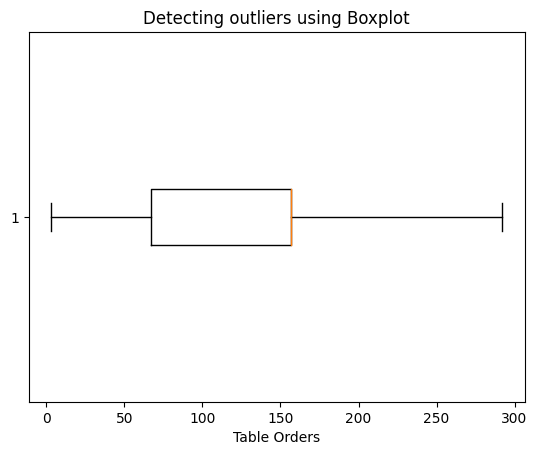

In [41]:
plt.boxplot(orders['cancellations'], vert=False)
plt.title("Detecting outliers using Boxplot")
plt.xlabel('Table Orders')

In [42]:
orders['cancellations'].describe()

count    10716.000000
mean       122.625233
std         62.715080
min          3.000000
25%         67.000000
50%        157.000000
75%        157.000000
max        292.000000
Name: cancellations, dtype: float64

## Save Data Cleansing Results using Python to SQLite

In [43]:
orders.to_sql(name='orders', con=conn, if_exists='replace', index=False)

10716

In [44]:
pd.read_sql_query("""
                    SELECT *
                    FROM orders
                    WHERE order_id IS NULL
                """, conn)

,order_datetime,longitude,latitude,order_eta,order_id,order_status,driver_assigned,cancellations


In [45]:
offers.to_sql(name='offers', con=conn, if_exists='replace', index=False)

97967

In [46]:
pd.read_sql_query("""
                    SELECT *
                    FROM offers
                    WHERE order_id IS NULL
                """, conn)

,order_id,offer_id


## Save Data to CSV

In [47]:
orders.to_csv('orders.csv', index=False)

In [48]:
offers.to_csv('offers.csv', index=False)

**EXPLORATORY DATA ANALYSIS**

1. Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

In [49]:
reason_failure = pd.read_sql_query("""
                                    WITH reason_failure AS (
                                        SELECT
                                            COUNT(order_id) AS total_order,
                                            driver_assigned,
                                            CASE
                                                WHEN order_status = 4 THEN 'Client Canceled'
                                                ELSE 'System Rejected'
                                            END AS status_canceled
                                        FROM orders
                                        GROUP BY 2, 3
                                    )
                                        SELECT
                                            total_order,
                                            status_canceled,
                                            CASE
                                                WHEN driver_assigned = 0 THEN 'No'
                                                ELSE 'Yes'
                                            END AS status_driver
                                        FROM reason_failure
                                        ORDER BY total_order DESC
                                    """, conn)
reason_failure

,total_order,status_canceled,status_driver
0,4496,Client Canceled,No
1,3406,System Rejected,No
2,2811,Client Canceled,Yes
3,3,System Rejected,Yes


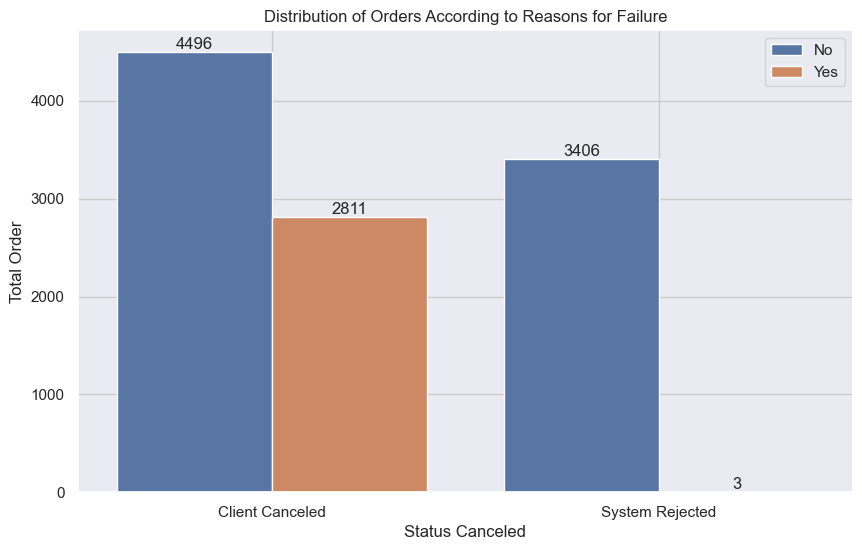

In [50]:
sns.set()
plt.figure(figsize=(10, 6))

ax = sns.barplot(x='status_canceled', y='total_order', hue='status_driver', data=reason_failure)
for i in ax.containers:
    ax.bar_label(i, )

ax.set_title('Distribution of Orders According to Reasons for Failure')
ax.grid(color='#cccccc')
ax.set_xlabel('Status Canceled')
ax.set_ylabel('Total Order')
ax.set_xticklabels(reason_failure['status_canceled'].unique().astype(str), rotation='horizontal')
ax.legend()

plt.show()

2. Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

In [51]:
failed_orders = pd.read_sql_query("""
                                    WITH failed_orders AS (
                                        SELECT
                                            COUNT(order_id) AS total_order,
                                            STRFTIME('%H', order_datetime) AS order_hours
                                        FROM orders
                                        GROUP BY 2
                                    )
                                        SELECT *
                                        FROM failed_orders
                                        ORDER BY order_hours
                                    """, conn)
failed_orders

,total_order,order_hours
0,683,00
1,471,01
2,555,02
3,513,03
4,152,04
5,67,05
6,159,06
7,447,07
8,1082,08
9,412,09


C:\Users\alfia\AppData\Local\Temp\ipykernel_8668\1665563818.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(failed_orders['order_hours'].unique().astype(str), rotation='horizontal')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


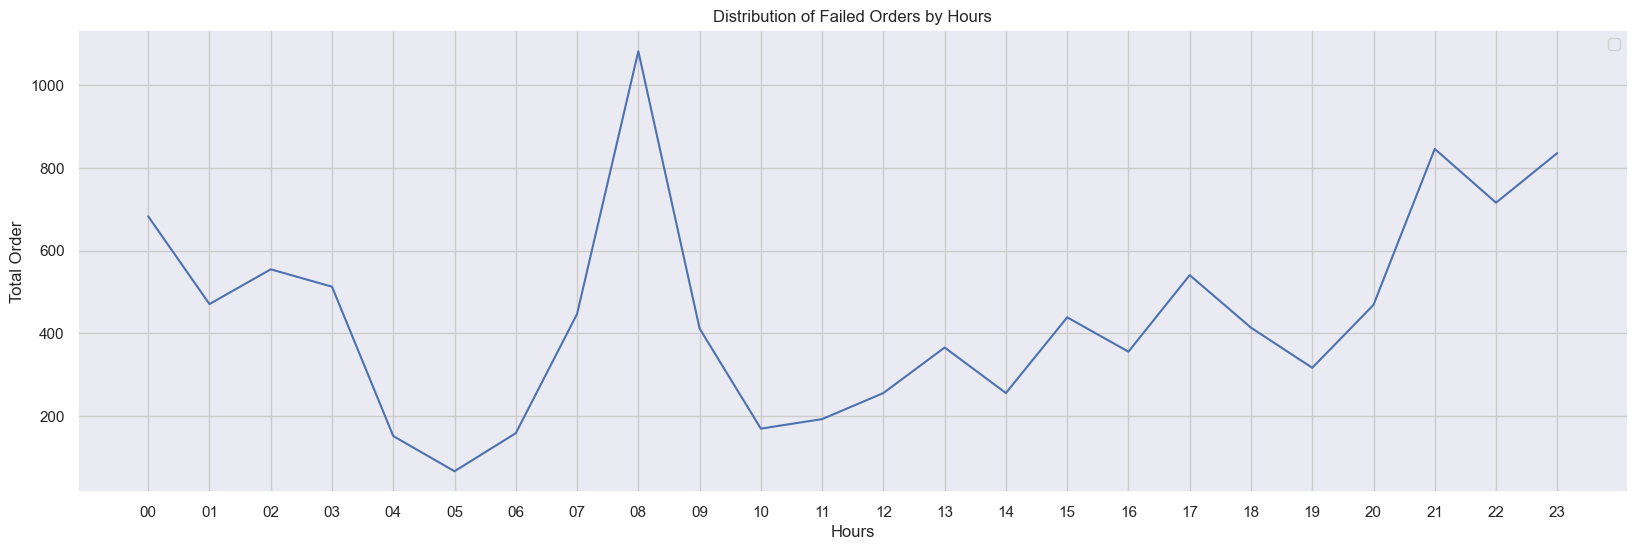

In [52]:
sns.set()
plt.figure(figsize=(20, 6))

ax = sns.lineplot(x='order_hours', y='total_order', data=failed_orders)
for i in ax.containers:
    ax.bar_label(i, )

ax.set_title('Distribution of Failed Orders by Hours')
ax.grid(color='#cccccc')
ax.set_xlabel('Hours')
ax.set_ylabel('Total Order')
ax.set_xticklabels(failed_orders['order_hours'].unique().astype(str), rotation='horizontal')
ax.legend()

plt.show()

3. Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

In [53]:
average_cancellation = pd.read_sql_query("""
                                            WITH average_cancellation AS (
                                                SELECT
                                                    AVG(cancellations) AS avg_cancel,
                                                    STRFTIME('%H', order_datetime) AS order_hours,
                                                    CASE
                                                        WHEN driver_assigned = 0 THEN 'No'
                                                        ELSE 'Yes'
                                                    END AS status_driver
                                                FROM orders
                                                GROUP BY 2, 3
                                        )
                                                SELECT *
                                                FROM average_cancellation
                                                ORDER BY order_hours
                                            """, conn)
average_cancellation

,avg_cancel,order_hours,status_driver
0,127.372549,00,No
1,134.934426,00,Yes
2,122.276762,01,No
3,122.170455,01,Yes
4,128.846960,02,No
5,132.294872,02,Yes
6,129.378619,03,No
7,111.171875,03,Yes
8,125.090090,04,No
9,112.487805,04,Yes


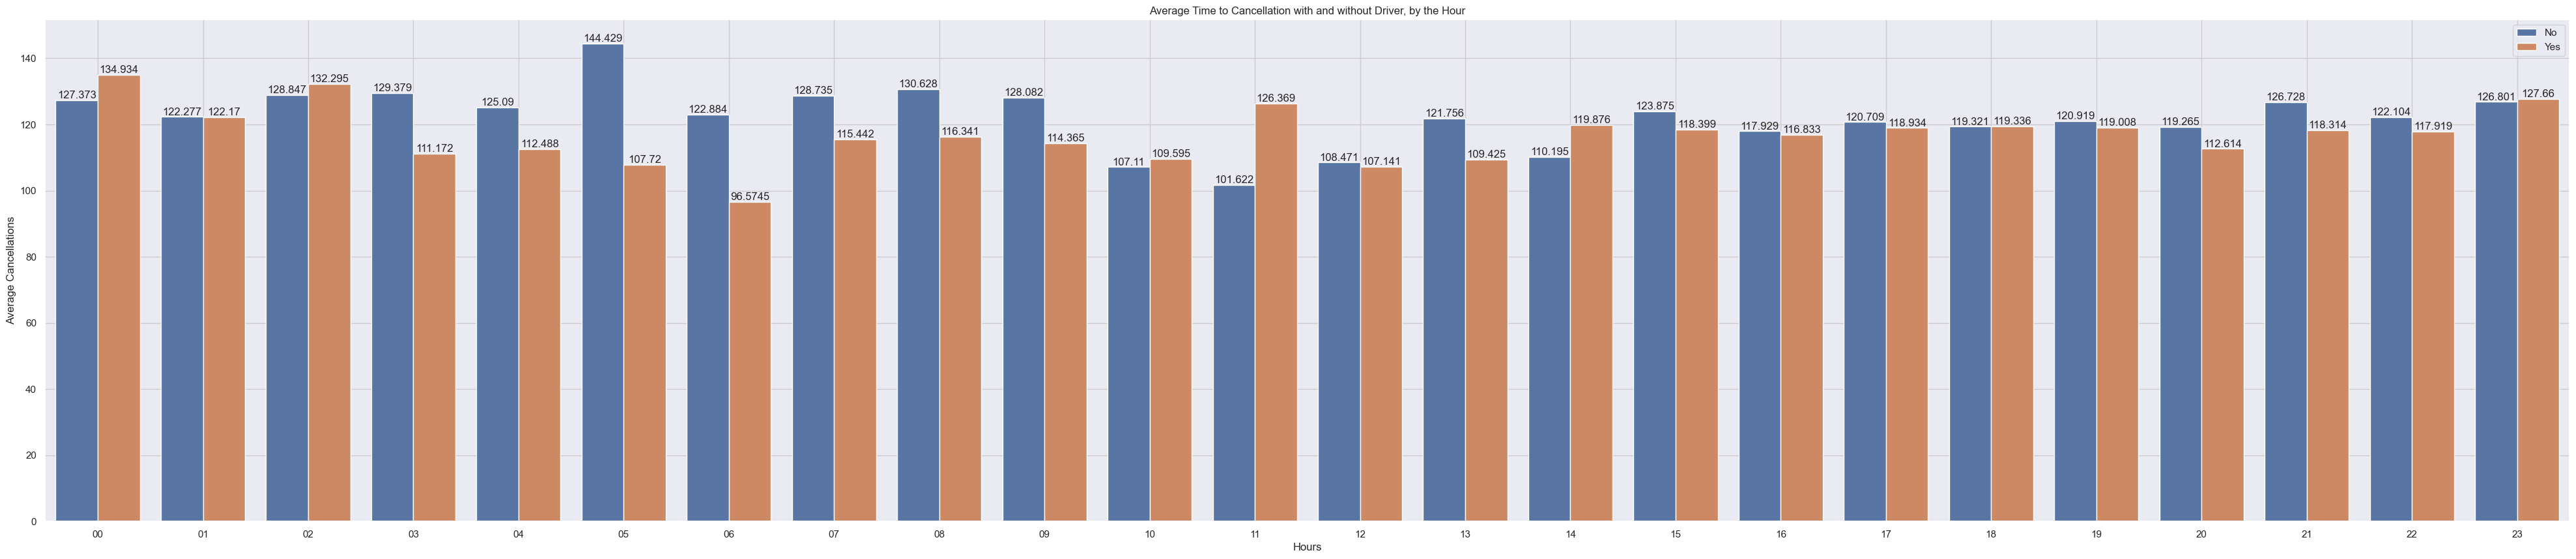

In [54]:
sns.set()
plt.figure(figsize=(50, 10))

ax = sns.barplot(x='order_hours', y='avg_cancel', hue='status_driver', data=average_cancellation)
for i in ax.containers:
    ax.bar_label(i, )

ax.set_title('Average Time to Cancellation with and without Driver, by the Hour')
ax.grid(color='#cccccc')
ax.set_xlabel('Hours')
ax.set_ylabel('Average Cancellations')
ax.set_xticklabels(average_cancellation['order_hours'].unique().astype(str), rotation='horizontal')
ax.legend()

plt.show()

4. Plot the distribution of average ETA by hours. How can this plot be explained?

In [56]:
average_eta = pd.read_sql_query("""
                                    WITH average_eta AS (
                                        SELECT
                                            ROUND(AVG(order_eta), 2) AS average_eta,
                                            STRFTIME('%H', order_datetime) AS order_hours,
                                            CASE
                                                WHEN driver_assigned = 0 THEN 'No'
                                                ELSE 'Yes'
                                            END AS status_driver,
                                            CASE
                                                WHEN order_status = 4 THEN 'Client Canceled'
                                                ELSE 'System Rejected'
                                            END AS status_canceled
                                        FROM orders
                                        GROUP BY 2, 3, 4
                                )
                                        SELECT
                                            average_eta,
                                            order_hours,
                                            status_driver  || ', ' || status_canceled AS status
                                        FROM average_eta
                                        ORDER BY order_hours
                                """, conn)
average_eta

,average_eta,order_hours,status
0,441.00,00,"No, Client Canceled"
1,441.00,00,"No, System Rejected"
2,360.94,00,"Yes, Client Canceled"
3,179.00,00,"Yes, System Rejected"
4,441.00,01,"No, Client Canceled"
...,...,...,...
69,441.00,22,"No, System Rejected"
70,372.74,22,"Yes, Client Canceled"
71,441.00,23,"No, Client Canceled"
72,441.00,23,"No, System Rejected"


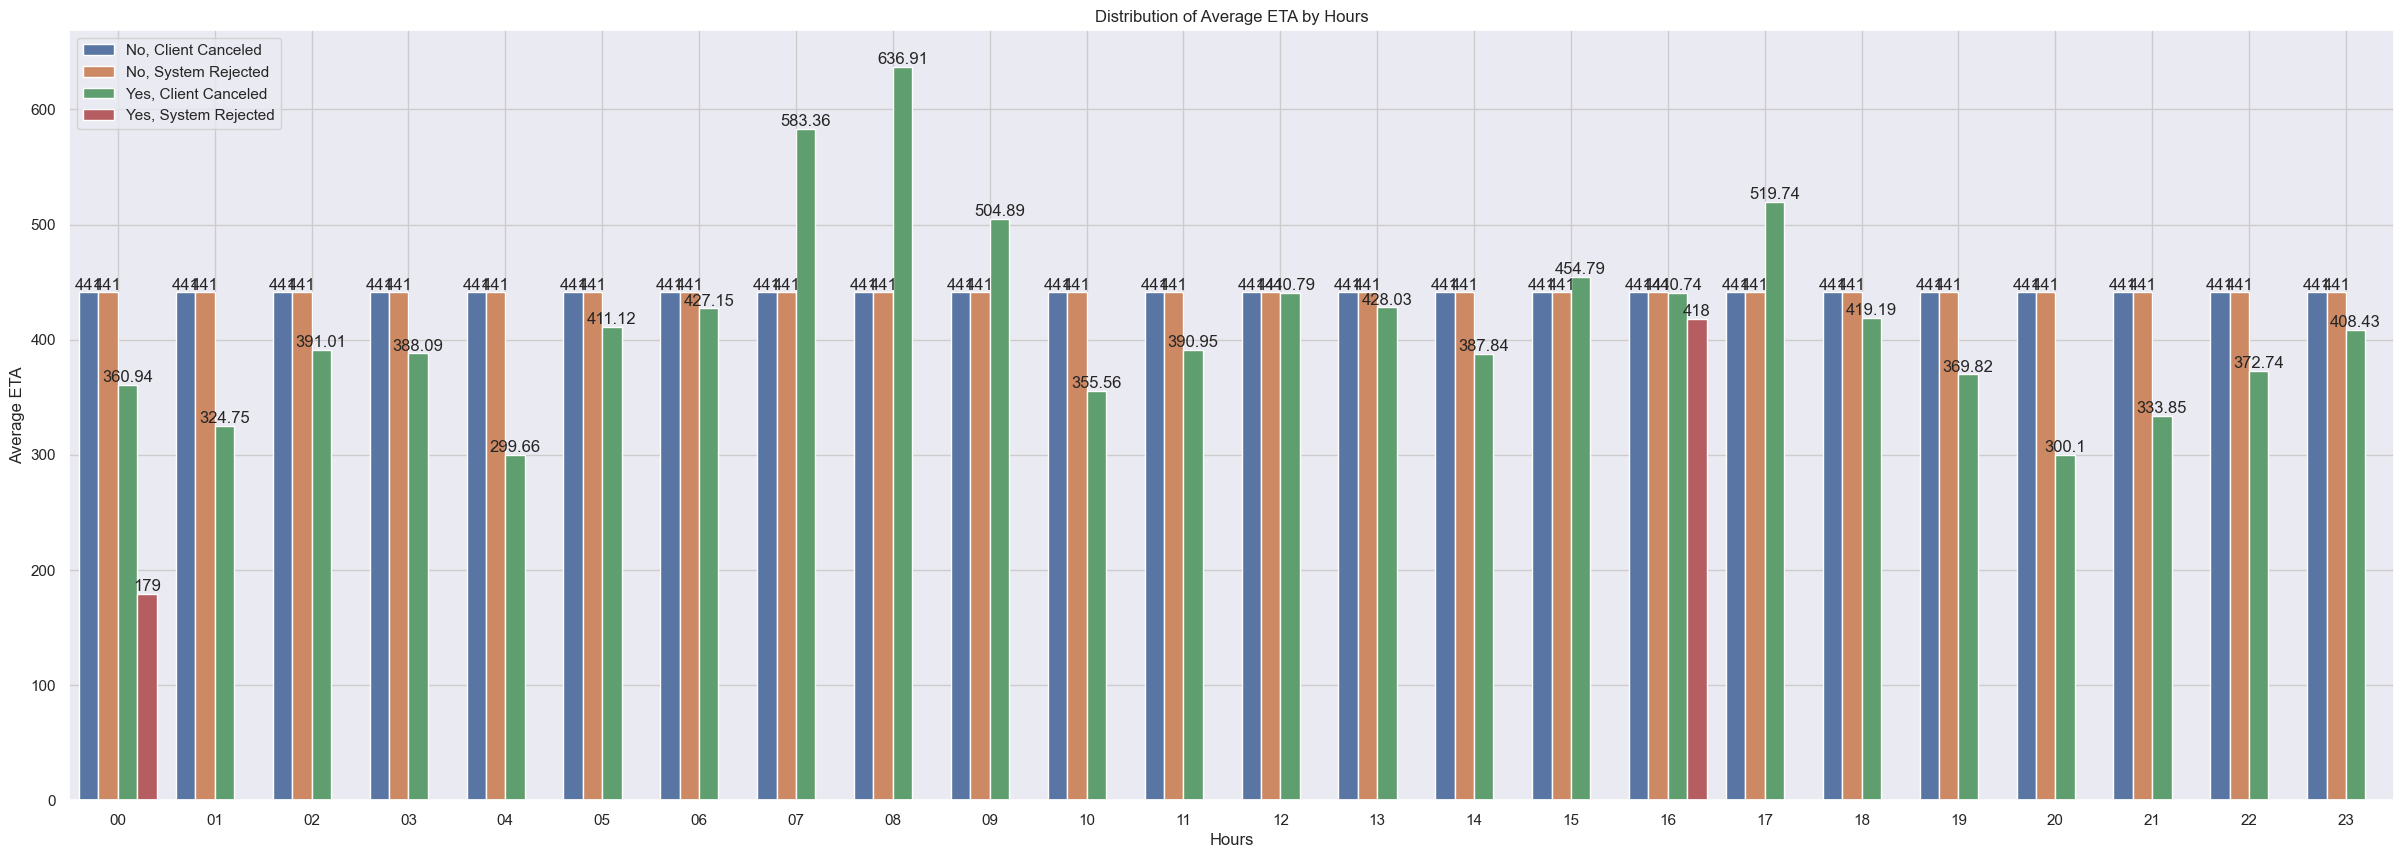

In [58]:
sns.set()
plt.figure(figsize=(30, 10))

ax = sns.barplot(x='order_hours', y='average_eta', hue='status', data=average_eta)
for i in ax.containers:
    ax.bar_label(i, )

ax.set_title('Distribution of Average ETA by Hours')
ax.grid(color='#cccccc')
ax.set_xlabel('Hours')
ax.set_ylabel('Average ETA')
ax.set_xticklabels(average_eta['order_hours'].unique().astype(str), rotation='horizontal')
ax.legend()

plt.show()

**Insight and Recommendation**

**Insight**

1. Most order failures are caused when the driver has not been assigned, whether it is canceled by the customer or the system rejects it.
2. The most order failures occur at 8am.
3. Order failures with the highest average cancel time when the driver has not been assigned at 6 a.m. and when the driver has been assigned at 12 am.
4. order failures when before the arrival of the order most often occur due to canceling from customers and it happens most often at 8 am.

**Recommendation**

1. Most order failures are when drivers have not been assigned, this could be due to the lack of available drivers.
2. The most order failures occur at 8 am, this may be due to the level of order booking by customers experiencing very high traffic.
3. Order failures with the highest average cancel time are when the driver has not been assigned which is most at 6 am, this can occur because many drivers are not ready to start work at that hour and when the driver has been assigned most at 12 pm, this can be caused by many drivers who are running orders.
4. Failure of orders before the arrival of orders, namely when customers cancel at most at 8 am, this can occur possibly because customers need orders quickly because at that time customers want to leave for work.

From the results of the analysis, I will provide recommendations so that the company can increase the number of drivers to be able to reduce the number of order failures in the future.